In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [2]:
file_path = 'output_dataset.csv'
df = pd.read_csv(file_path)

In [3]:
df.head()

,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,...,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,file_name,label
0,139.674831,828,0.460955,0.216722,2346.091210,2668.118008,4679.935723,0.055782,-135.78252,150.84305,...,-2.779924,-3.657768,-1.657589,-2.536046,2.946141,1.749066,6.159016,-3.283215,505.wav,Trendy
1,100.446429,446,0.486563,0.221918,3689.389831,4123.870155,8321.281198,0.066274,-137.79738,119.81668,...,-3.176606,-3.027638,-1.519534,2.586739,-0.295558,-1.474686,-0.263929,-2.707898,Addison Rae - Diet Pepsi (Official Video).wav,Trendy
2,152.027027,597,0.390602,0.161716,2474.960665,3371.210728,5261.825899,0.041952,-200.20476,150.19890,...,-4.158189,-5.560582,4.906631,-7.860816,-3.499030,-3.888813,-5.766799,-3.742697,Alec Benjamin - Let Me Down Slowly [Official M...,Trendy
3,99.384014,651,0.475451,0.272566,2357.030310,3003.164199,5165.984103,0.041789,-133.61790,146.47585,...,-4.004008,-3.391630,2.341435,-8.277086,2.656603,-0.836905,-0.522437,-6.332903,"Alemán, Neton Vega - Te Quería Ver (Letra).wav",Trendy
4,125.000000,793,0.469422,0.256264,2817.362169,3722.647405,5970.212484,0.048454,-131.85693,143.35591,...,0.447898,4.257901,0.661160,2.707422,-1.500231,1.968905,-1.632458,0.870351,Alex Warren - Carry You Home (Official Video).wav,Trendy


In [4]:
# Loại bỏ ngoại lai bằng Z-score ---
from scipy import stats
from sklearn.utils import resample
numeric_cols = df.select_dtypes(include=np.number).columns
z_scores = np.abs(stats.zscore(df[numeric_cols]))
df_clean = df[(z_scores < 3).all(axis=1)]
print(f"✅ Dữ liệu sau khi loại bỏ ngoại lai: {df_clean.shape[0]} hàng")


✅ Dữ liệu sau khi loại bỏ ngoại lai: 441 hàng


In [6]:
# Bước 1: Xác định cột số
numeric_cols = df.select_dtypes(include=np.number).columns

# Bước 2: Tính Z-score và loại bỏ ngoại lai (Z > 3)
z_scores = np.abs(stats.zscore(df[numeric_cols]))
df_clean = df[(z_scores < 3).all(axis=1)]

# Bước 3: Tạo bảng so sánh trước và sau cho cột 'beats'
summary_before = {
    "Số lượng": df["beats"].count(),
    "Min": df["beats"].min(),
    "Max": df["beats"].max(),
    "Trung bình": df["beats"].mean(),
    "Độ lệch chuẩn": df["beats"].std()
}

summary_after = {
    "Số lượng": df_clean["beats"].count(),
    "Min": df_clean["beats"].min(),
    "Max": df_clean["beats"].max(),
    "Trung bình": df_clean["beats"].mean(),
    "Độ lệch chuẩn": df_clean["beats"].std()
}

# Bước 4: In bảng so sánh
comparison_df = pd.DataFrame([summary_before, summary_after], index=["Trước xử lý", "Sau xử lý"])
print("📊 Bảng so sánh thuộc tính 'beats' trước và sau khi loại bỏ ngoại lai:\n")
print(comparison_df)

📊 Bảng so sánh thuộc tính 'beats' trước và sau khi loại bỏ ngoại lai:

             Số lượng  Min   Max  Trung bình  Độ lệch chuẩn
Trước xử lý       488   62  5373  922.114754     629.316254
Sau xử lý         441  189  2763  844.095238     398.326003


C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

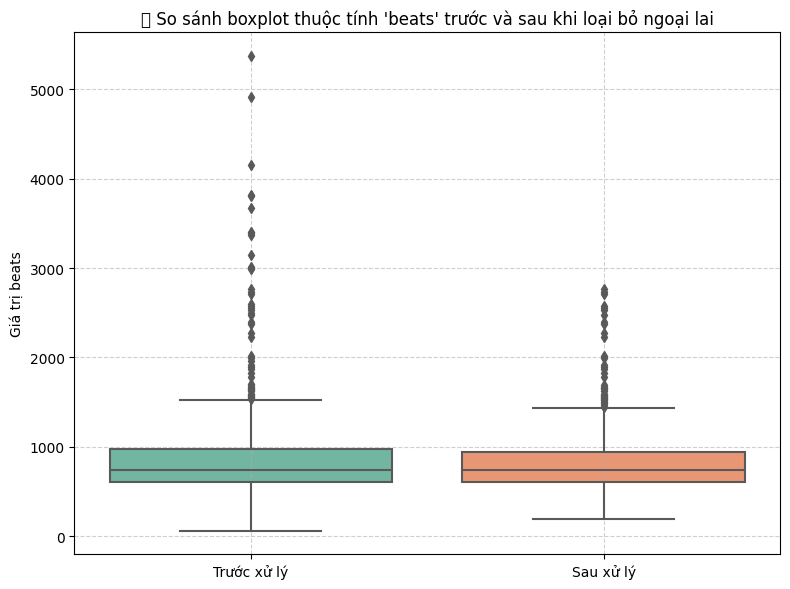

In [7]:
# Tạo DataFrame tạm để vẽ boxplot
beats_comparison = pd.DataFrame({
    "Giá trị": pd.concat([df["beats"], df_clean["beats"]]),
    "Trạng thái": ["Trước xử lý"] * len(df) + ["Sau xử lý"] * len(df_clean)
})

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
sns.boxplot(x="Trạng thái", y="Giá trị", data=beats_comparison, palette="Set2")
plt.title("📦 So sánh boxplot thuộc tính 'beats' trước và sau khi loại bỏ ngoại lai")
plt.ylabel("Giá trị beats")
plt.xlabel("")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [8]:
max_count = df_clean['label'].value_counts().max()
balanced_df_list = []

for label in df_clean['label'].unique():
    label_df = df_clean[df_clean['label'] == label]
    if len(label_df) < max_count:
        label_df_upsampled = resample(label_df, 
                                      replace=True, 
                                      n_samples=max_count, 
                                      random_state=42)
    else:
        label_df_upsampled = label_df
    balanced_df_list.append(label_df_upsampled)

balanced_df = pd.concat(balanced_df_list).sample(frac=1, random_state=42).reset_index(drop=True)

C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

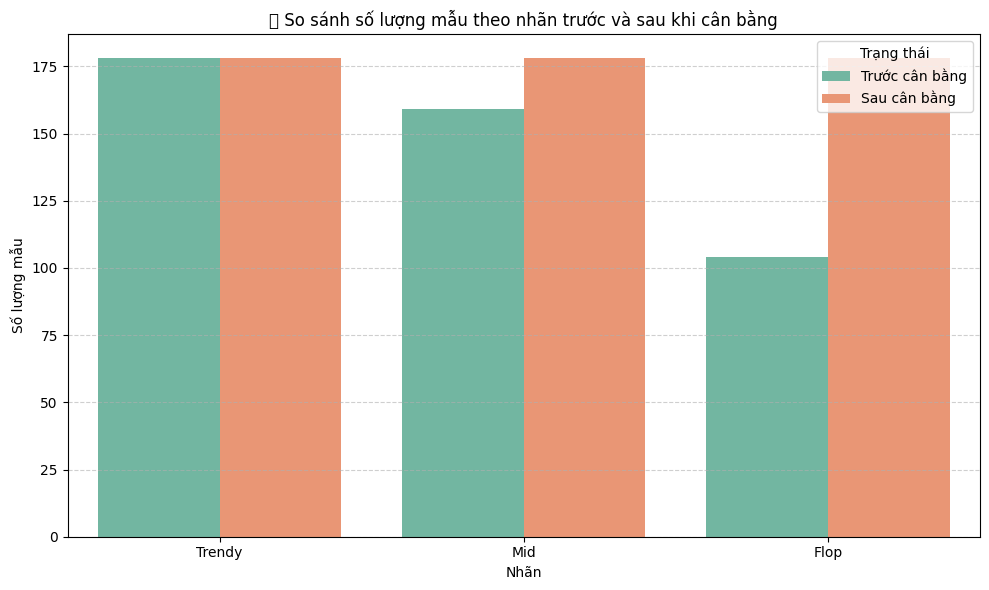

In [9]:
# Bước 1: Đếm số lượng mẫu theo nhãn trước và sau khi cân bằng
label_counts_before = df_clean['label'].value_counts().reset_index()
label_counts_before.columns = ['label', 'count']
label_counts_before['Trạng thái'] = 'Trước cân bằng'

label_counts_after = balanced_df['label'].value_counts().reset_index()
label_counts_after.columns = ['label', 'count']
label_counts_after['Trạng thái'] = 'Sau cân bằng'

# Bước 2: Gộp dữ liệu để vẽ biểu đồ
label_counts = pd.concat([label_counts_before, label_counts_after])

# Bước 3: Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(data=label_counts, x='label', y='count', hue='Trạng thái', palette='Set2')

plt.title("📊 So sánh số lượng mẫu theo nhãn trước và sau khi cân bằng")
plt.xlabel("Nhãn")
plt.ylabel("Số lượng mẫu")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [10]:
print("\n📊 Số lượng mỗi nhãn sau cân bằng:")
print(balanced_df['label'].value_counts())


📊 Số lượng mỗi nhãn sau cân bằng:
label
Mid       178
Trendy    178
Flop      178
Name: count, dtype: int64


C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categori

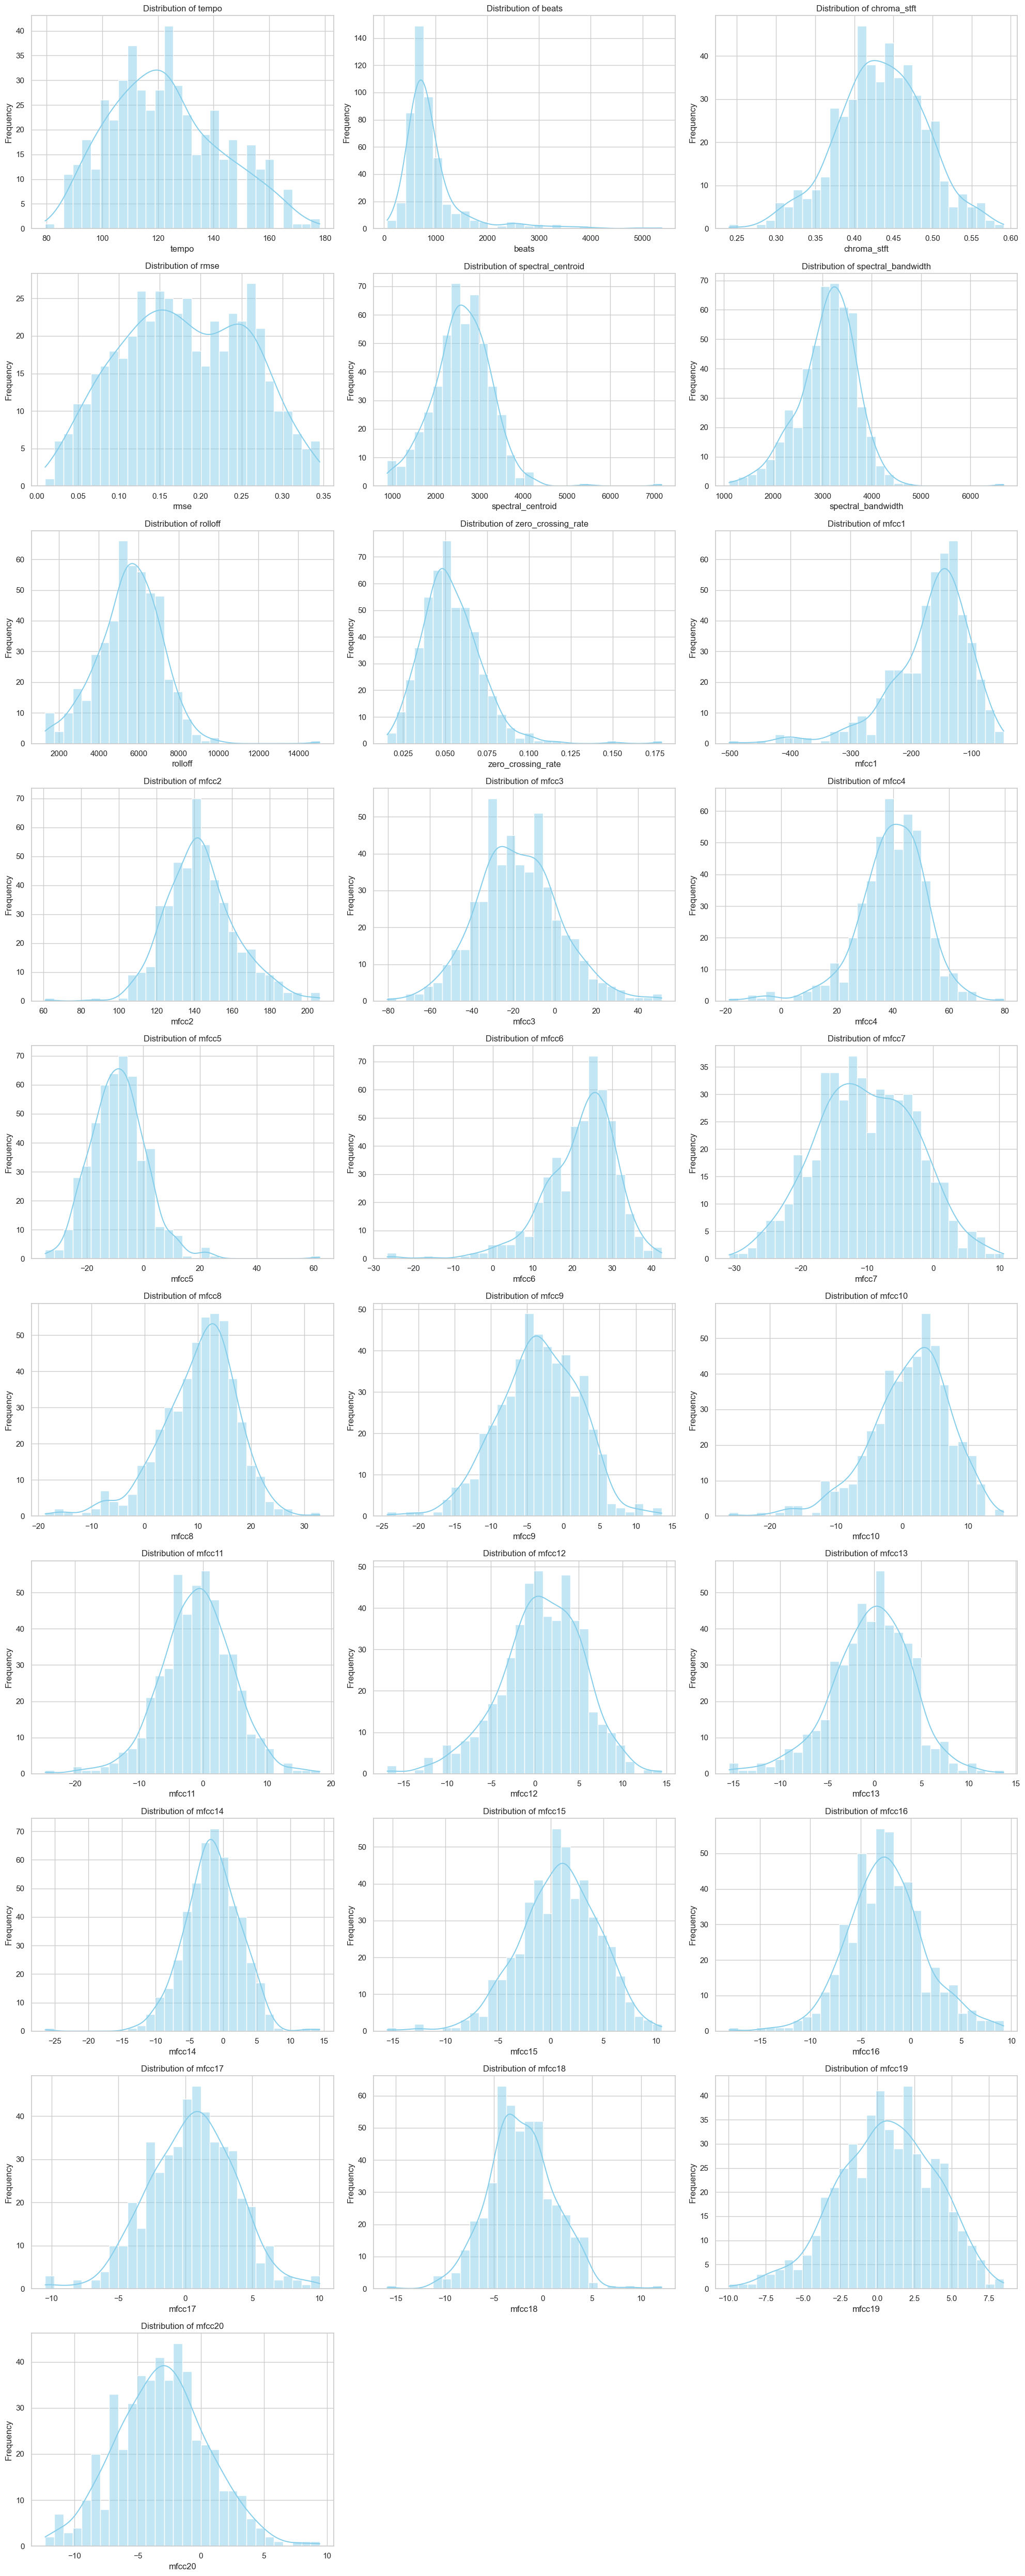

In [11]:
sns.set(style="whitegrid")

num_cols = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 50))  # Tùy chỉnh kích thước tổng của toàn bộ biểu đồ

for i, col in enumerate(num_cols, 1):
    plt.subplot(10, 3, i)  # 10 hàng, 3 cột biểu đồ con
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()

plt.show()

ValueError: Could not interpret input 'Label'

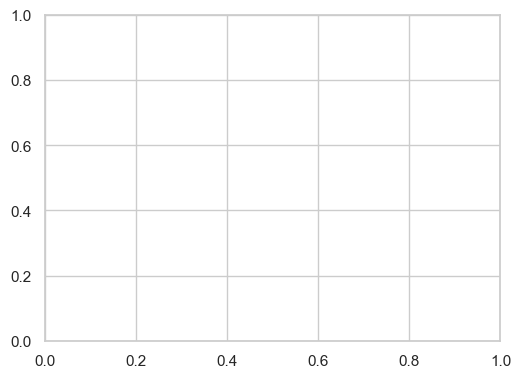

In [14]:
sns.set(style="whitegrid")

num_cols = balanced_df.select_dtypes(include=['float64', 'int64']).columns

n_cols = 3  # 3 biểu đồ mỗi dòng
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # Tính số dòng cần

plt.figure(figsize=(20, n_rows * 5))  # Kích thước phù hợp với số hàng

for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=balanced_df, x='Label', y=col, palette='colorblind')  # Hoặc 'pastel', 'husl', 'Set3'
    plt.title(f'{col} Theo nhãn', fontsize=12)
    plt.xlabel('Nhãn (Nhóm nổi tiếng)')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

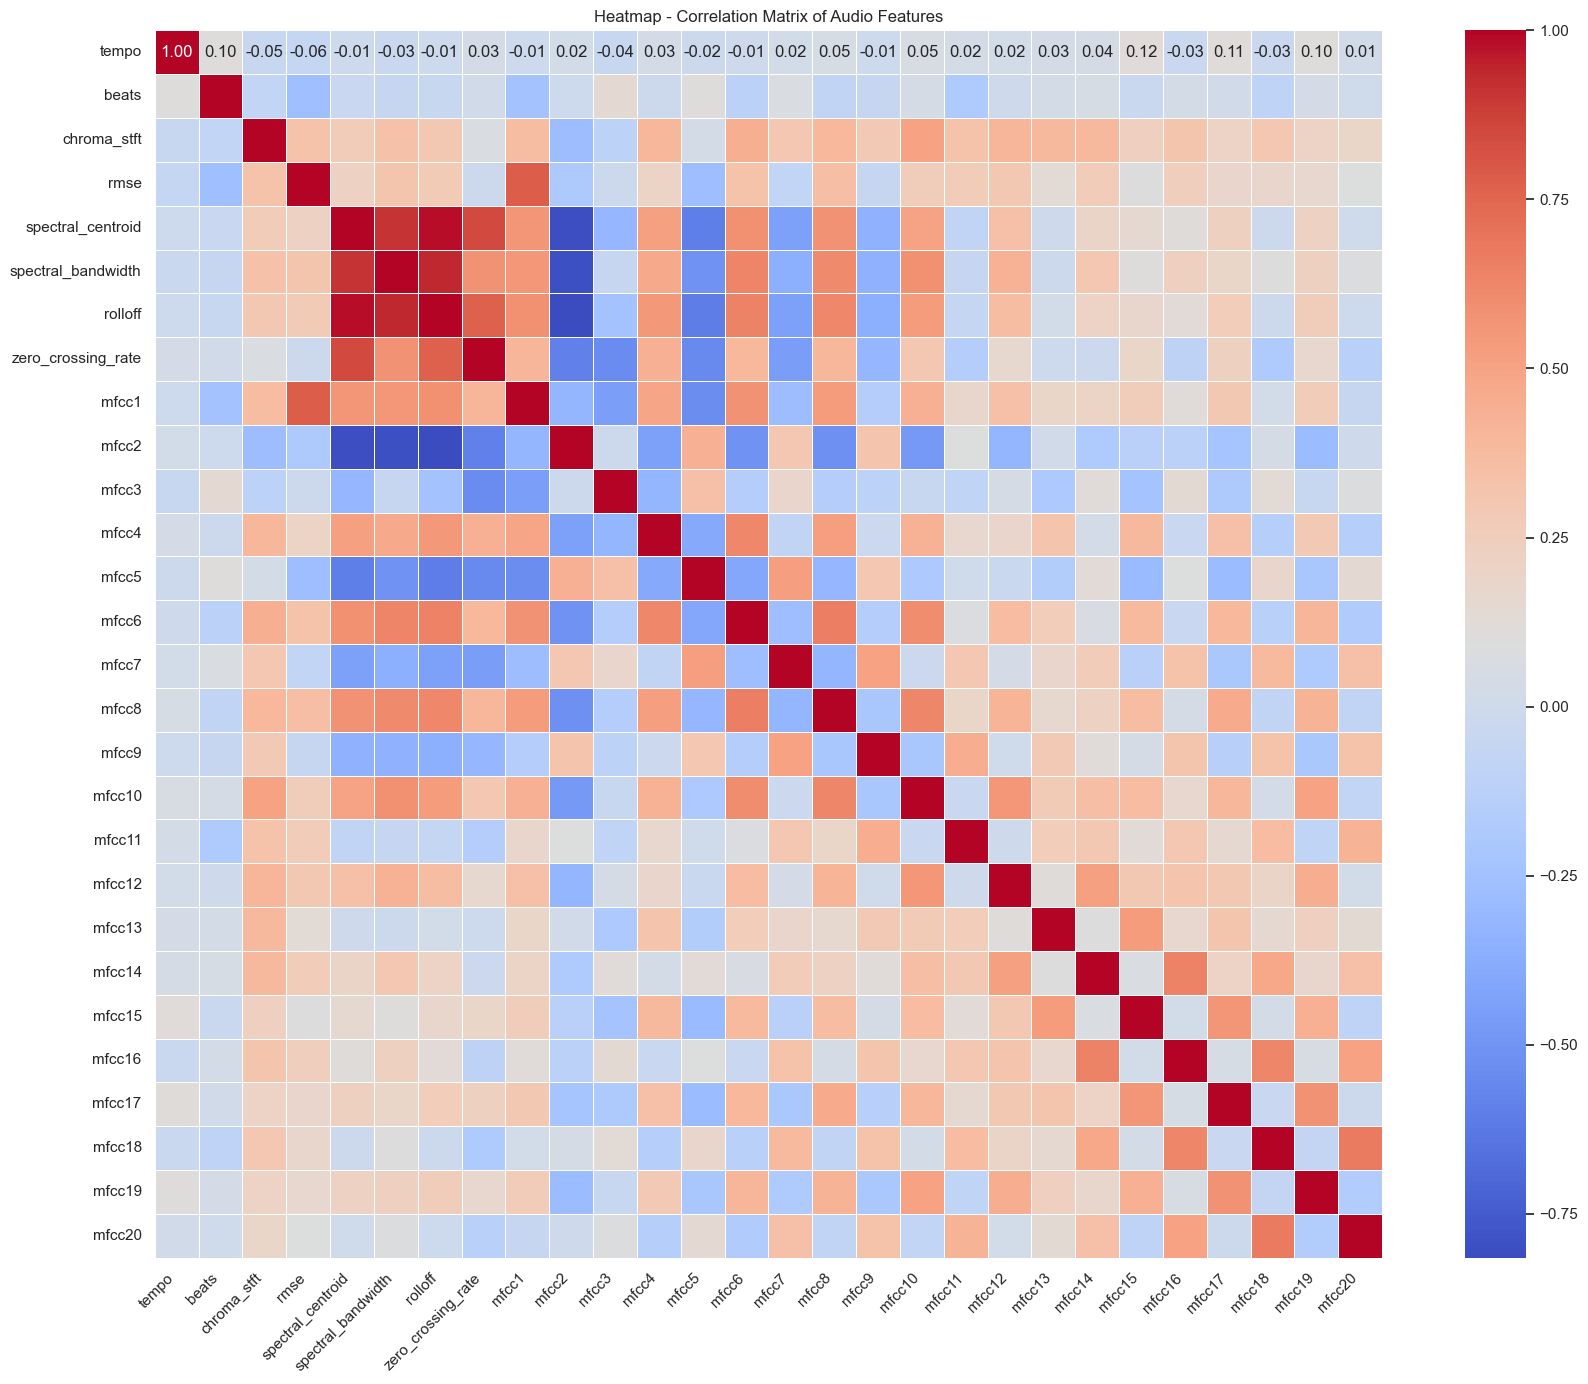

In [14]:
num_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = num_df.corr()
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5)
plt.title('Heatmap - Correlation Matrix of Audio Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Bước 6: Hiển thị biểu đồ
plt.show()

C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

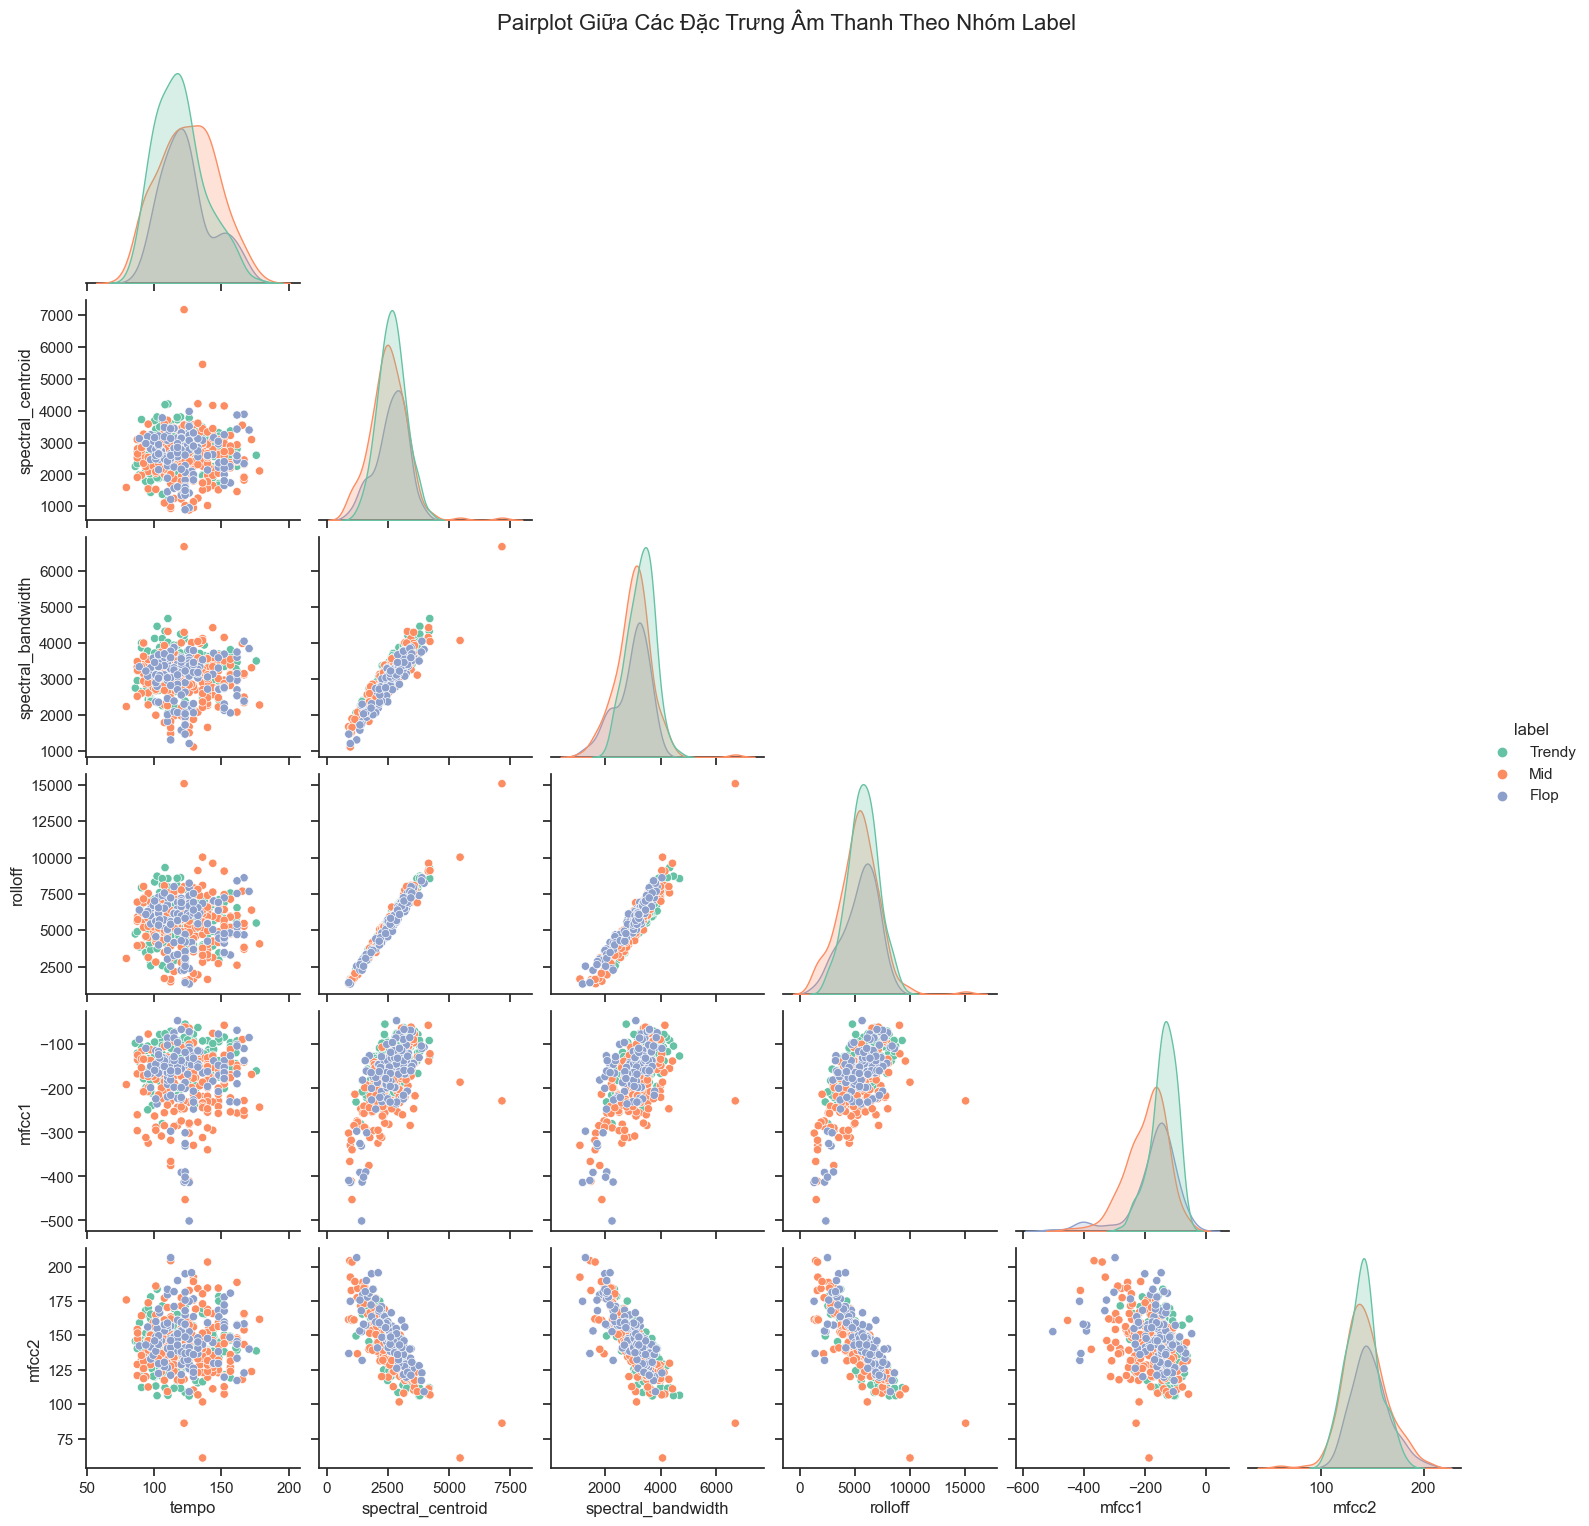

In [15]:
selected_features = [
    'tempo',
    'spectral_centroid',
    'spectral_bandwidth',
    'rolloff',
    'mfcc1',
    'mfcc2',
    'label'  # thêm nhãn để phân nhóm
]

pairplot_df = df[selected_features]

sns.set(style="ticks")
sns.pairplot(pairplot_df, hue="label", palette="Set2", corner=True, diag_kind="kde")

plt.suptitle("Pairplot Giữa Các Đặc Trưng Âm Thanh Theo Nhóm Label", y=1.02, fontsize=16)
plt.show()

In [15]:
# 🎯 Chia dữ liệu thành X (features) và y (labels)
X = balanced_df.drop(columns=['file_name', 'label'])
y = balanced_df['label']

In [16]:
# 🔤 Encode nhãn
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [17]:
# 🔀 Chia train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=3
)

In [18]:
# 🔧 Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# 🤖 Khởi tạo các mô hình
models = {
    "SVM (Linear)": SVC(kernel='linear'),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

In [20]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
# Lưu kết quả đánh giá
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    support = len(y_test)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "Support": support
    })

# Chuyển kết quả sang DataFrame
results_df = pd.DataFrame(results)


In [21]:
# 📋 Tạo bảng kết quả
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
display(results_df)

,Model,Accuracy,Precision,Recall,F1-score,Support
0,SVM (Linear),0.775701,0.770610,0.775701,0.772457,107
1,KNN (k=5),0.747664,0.753185,0.747664,0.744798,107
2,Logistic Regression,0.785047,0.784177,0.785047,0.784507,107
3,XGBoost,0.934579,0.935541,0.934579,0.934091,107


C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

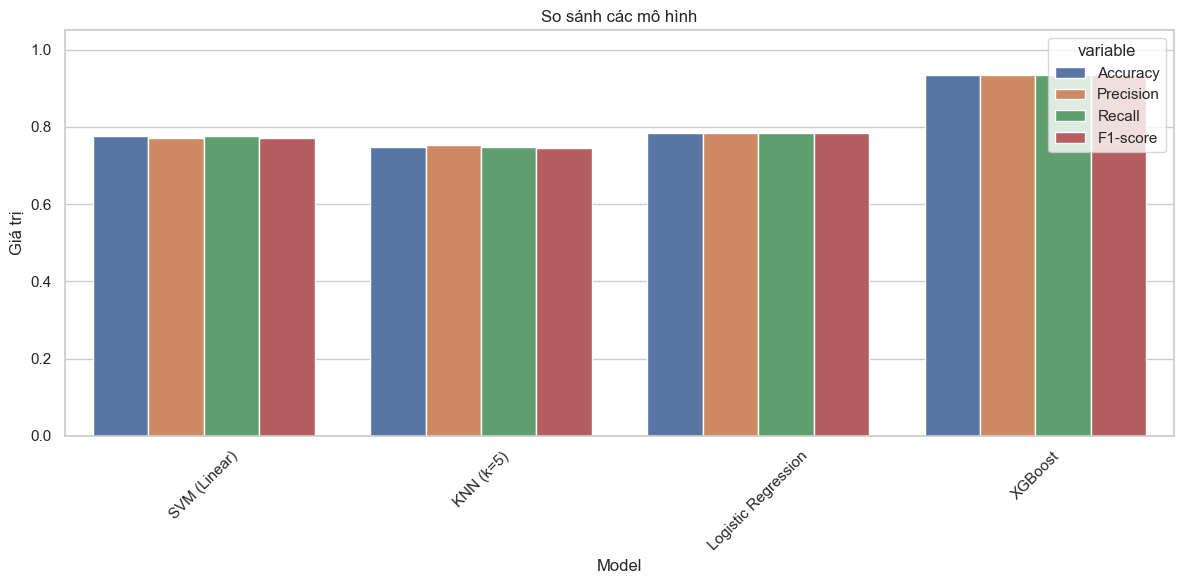

In [22]:
# Vẽ biểu đồ dạng cột
plt.figure(figsize=(12, 6))
results_melted = results_df.melt(id_vars="Model", value_vars=["Accuracy", "Precision", "Recall", "F1-score"])
sns.barplot(data=results_melted, x="Model", y="value", hue="variable")
plt.title("So sánh các mô hình")
plt.ylabel("Giá trị")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

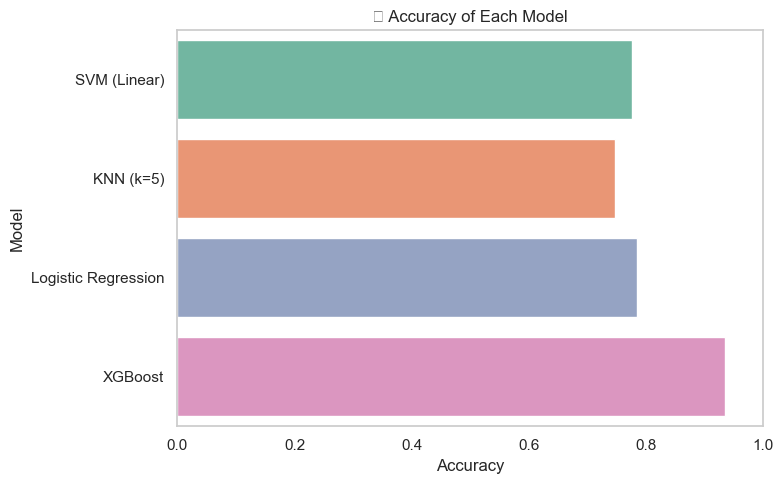

In [23]:
# 📈 Trực quan hóa độ chính xác
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x="Accuracy", y="Model", palette="Set2")
plt.title("🎯 Accuracy of Each Model")
plt.xlabel("Accuracy")
plt.xlim(0, 1)
plt.grid(axis='x')
plt.tight_layout()
plt.show()


📌 Classification Report for SVM (Linear):
              precision    recall  f1-score   support

           0       0.74      0.76      0.75        34
           1       0.66      0.59      0.62        32
           2       0.88      0.93      0.90        41

    accuracy                           0.78       107
   macro avg       0.76      0.76      0.76       107
weighted avg       0.77      0.78      0.77       107



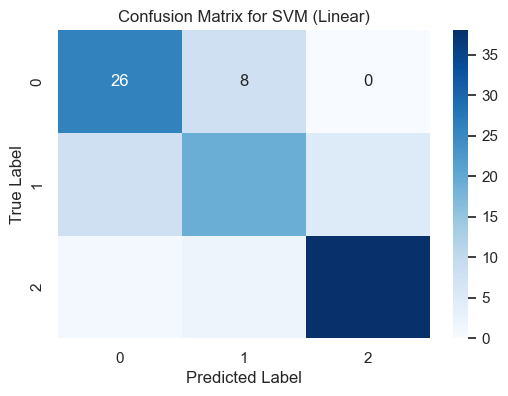


📌 Classification Report for KNN (k=5):
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        34
           1       0.70      0.59      0.64        32
           2       0.84      0.76      0.79        41

    accuracy                           0.75       107
   macro avg       0.75      0.74      0.74       107
weighted avg       0.75      0.75      0.74       107



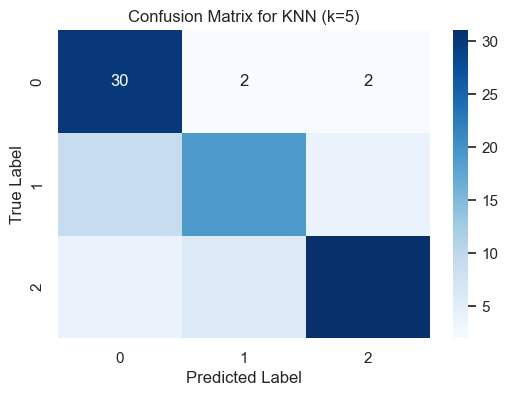


📌 Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.79      0.76      0.78        34
           1       0.66      0.66      0.66        32
           2       0.88      0.90      0.89        41

    accuracy                           0.79       107
   macro avg       0.78      0.77      0.77       107
weighted avg       0.78      0.79      0.78       107



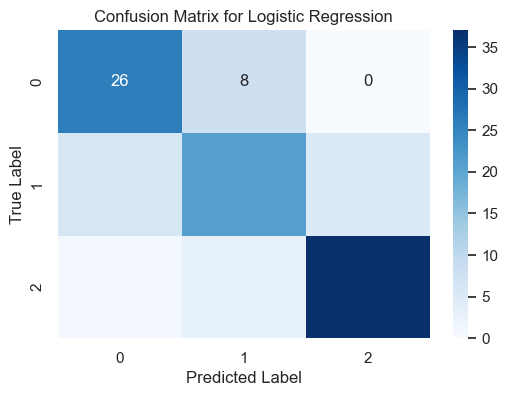


📌 Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        34
           1       0.97      0.88      0.92        32
           2       0.90      0.93      0.92        41

    accuracy                           0.93       107
   macro avg       0.94      0.93      0.94       107
weighted avg       0.94      0.93      0.93       107



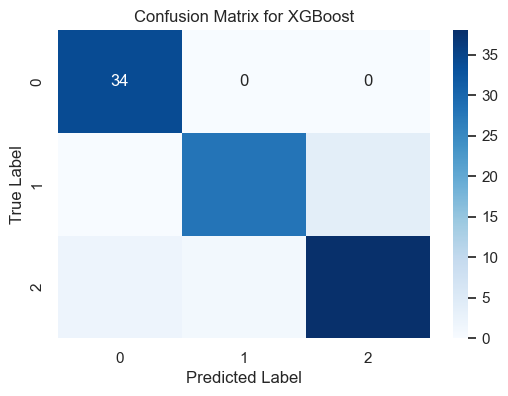

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
# Duyệt qua từng mô hình để in Classification Report và Confusion Matrix
for name, model in models.items():
    print(f"\n📌 Classification Report for {name}:")
    y_pred = model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))

    # Vẽ Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

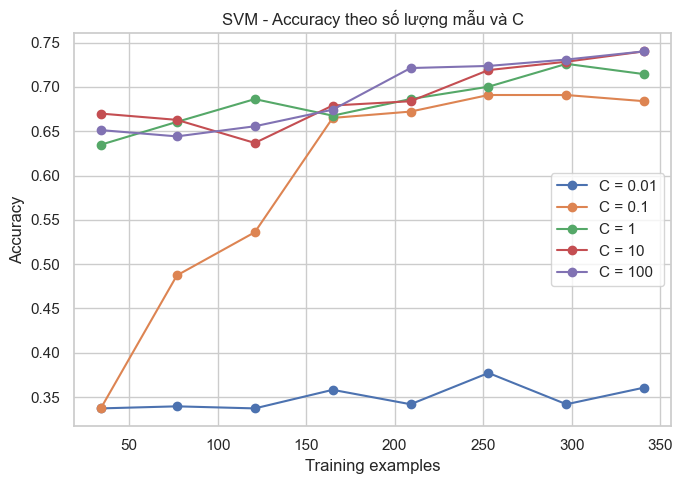

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
sns.set(style='whitegrid')
svm_C = [0.01, 0.1, 1, 10, 100]
plt.figure(figsize=(7, 5))

for c in svm_C:
    model = SVC(kernel='linear', C=c)
    train_sizes, _, test_scores = learning_curve(model, X_train_scaled, y_train, 
                                                 train_sizes=np.linspace(0.1, 1.0, 8), 
                                                 cv=5, scoring='accuracy', n_jobs=-1)
    mean_scores = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, mean_scores, marker='o', label=f'C = {c}')

plt.title("SVM - Accuracy theo số lượng mẫu và C")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


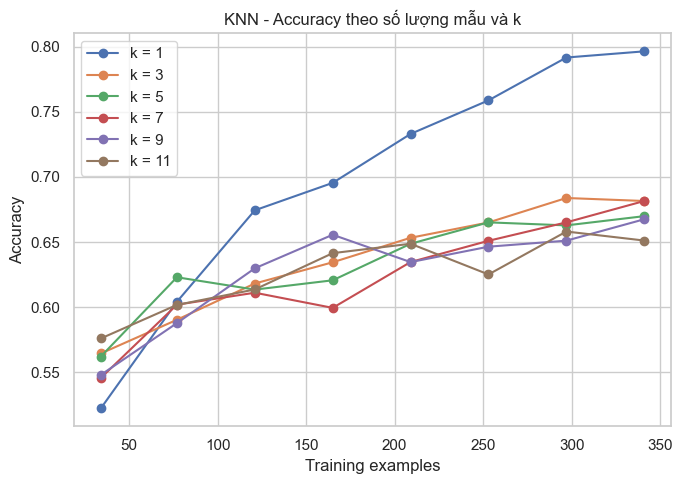

In [ ]:
knn_k = [1, 3, 5, 7, 9, 11]
plt.figure(figsize=(7, 5))

for k in knn_k:
    model = KNeighborsClassifier(n_neighbors=k)
    train_sizes, _, test_scores = learning_curve(model, X_train_scaled, y_train, 
                                                 train_sizes=np.linspace(0.1, 1.0, 8), 
                                                 cv=5, scoring='accuracy', n_jobs=-1)
    mean_scores = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, mean_scores, marker='o', label=f'k = {k}')

plt.title("KNN - Accuracy theo số lượng mẫu và k")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

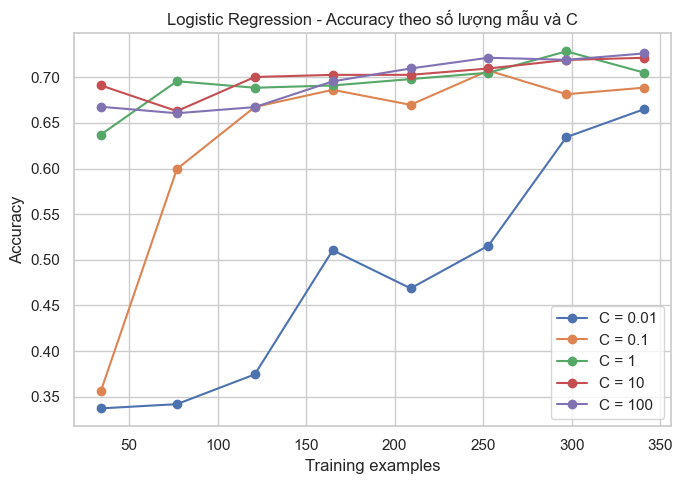

In [ ]:
log_C = [0.01, 0.1, 1, 10, 100]
plt.figure(figsize=(7, 5))

for c in log_C:
    model = LogisticRegression(C=c, max_iter=10000)
    train_sizes, _, test_scores = learning_curve(model, X_train_scaled, y_train, 
                                                 train_sizes=np.linspace(0.1, 1.0, 8), 
                                                 cv=5, scoring='accuracy', n_jobs=-1)
    mean_scores = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, mean_scores, marker='o', label=f'C = {c}')

plt.title("Logistic Regression - Accuracy theo số lượng mẫu và C")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

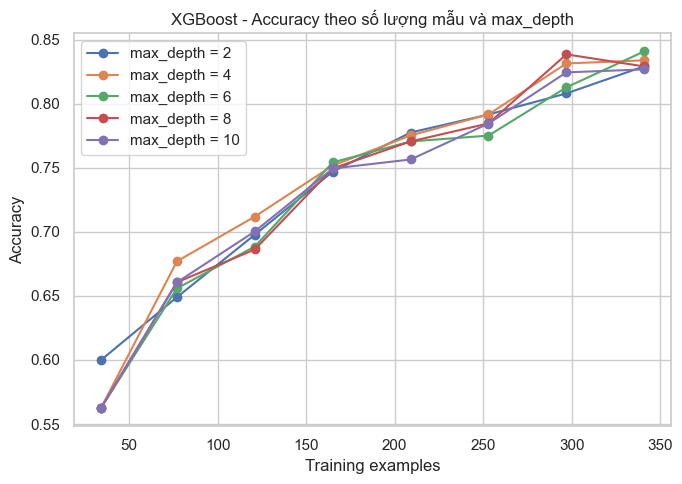

In [ ]:
xgb_depth = [2, 4, 6, 8, 10]
plt.figure(figsize=(7, 5))

for d in xgb_depth:
    model = xgb.XGBClassifier(max_depth=d, use_label_encoder=False, eval_metric='mlogloss')
    train_sizes, _, test_scores = learning_curve(model, X_train_scaled, y_train, 
                                                 train_sizes=np.linspace(0.1, 1.0, 8), 
                                                 cv=5, scoring='accuracy', n_jobs=-1)
    mean_scores = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, mean_scores, marker='o', label=f'max_depth = {d}')

plt.title("XGBoost - Accuracy theo số lượng mẫu và max_depth")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [26]:
# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ===============================
# 🔍 1. Tìm tham số tốt cho SVM
search_svm = BayesSearchCV(
    SVC(kernel='linear'),
    search_spaces={'C': (1e-3, 1e+3, 'log-uniform')},
    cv=cv_strategy,
    scoring='accuracy',
    n_iter=30,
    random_state=42
)
search_svm.fit(X_train_scaled, y_train)
best_c_svm = search_svm.best_params_['C']

# ===============================
# 🔍 2. Tìm tham số tốt cho KNN
search_knn = BayesSearchCV(
    KNeighborsClassifier(),
    search_spaces={'n_neighbors': (1, 20)},
    cv=cv_strategy,
    scoring='accuracy',
    n_iter=30,
    random_state=42
)
search_knn.fit(X_train_scaled, y_train)
best_k_knn = search_knn.best_params_['n_neighbors']

# ===============================
# 🔍 3. Tìm tham số tốt cho Logistic Regression
search_log = BayesSearchCV(
    LogisticRegression(max_iter=10000),
    search_spaces={'C': (1e-3, 1e+3, 'log-uniform')},
    cv=cv_strategy,
    scoring='accuracy',
    n_iter=30,
    random_state=42
)
search_log.fit(X_train_scaled, y_train)
best_c_log = search_log.best_params_['C']

# ===============================
# 🔍 4. Tìm tham số tốt cho XGBoost
search_xgb = BayesSearchCV(
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    search_spaces={'max_depth': (2, 12)},
    cv=cv_strategy,
    scoring='accuracy',
    n_iter=30,
    random_state=42
)
search_xgb.fit(X_train_scaled, y_train)
best_d_xgb = search_xgb.best_params_['max_depth']


C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [17] before, using random point [4]
  warnings.warn(
C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [1]
  warnings.warn(
C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [3] before, using random point [1]
  warnings.warn(
C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\opti

In [27]:
# ✅ Khởi tạo mô hình với tham số tốt nhất
models_best = {
    "SVM (best C)": SVC(kernel='linear', C=best_c_svm),
    "KNN (best k)": KNeighborsClassifier(n_neighbors=best_k_knn),
    "Logistic Regression (best C)": LogisticRegression(C=best_c_log, max_iter=10000),
    "XGBoost (best depth)": xgb.XGBClassifier(max_depth=best_d_xgb, use_label_encoder=False, eval_metric='mlogloss')
}

In [28]:
print(f"""✅ Tham số tối ưu tìm được:
- SVM (Linear): best C = {best_c_svm:.4f}
- KNN: best k = {best_k_knn}
- Logistic Regression: best C = {best_c_log:.4f}
- XGBoost: best max_depth = {best_d_xgb}
""")

✅ Tham số tối ưu tìm được:
- SVM (Linear): best C = 105.7621
- KNN: best k = 1
- Logistic Regression: best C = 74.8817
- XGBoost: best max_depth = 2




📌 Classification Report for SVM (C=105.7621):
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        34
           1       0.60      0.56      0.58        32
           2       0.86      0.90      0.88        41

    accuracy                           0.75       107
   macro avg       0.73      0.73      0.73       107
weighted avg       0.74      0.75      0.74       107



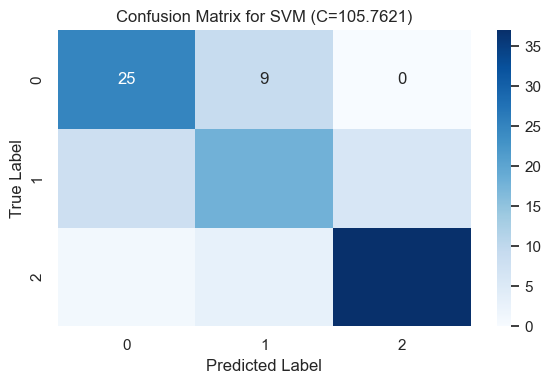


📌 Classification Report for KNN (k=1):
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        34
           1       0.87      0.81      0.84        32
           2       0.95      0.88      0.91        41

    accuracy                           0.90       107
   macro avg       0.90      0.90      0.89       107
weighted avg       0.90      0.90      0.90       107



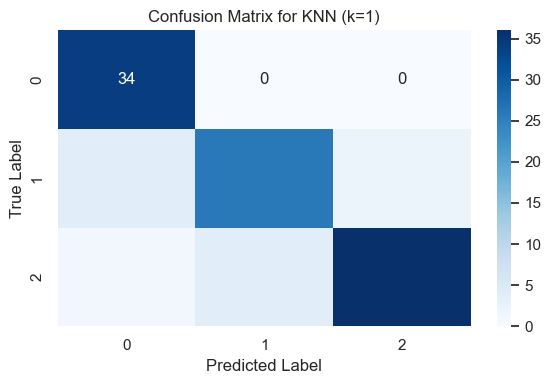


📌 Classification Report for Logistic Regression (C=74.8817):
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        34
           1       0.65      0.62      0.63        32
           2       0.86      0.88      0.87        41

    accuracy                           0.77       107
   macro avg       0.76      0.76      0.76       107
weighted avg       0.76      0.77      0.77       107



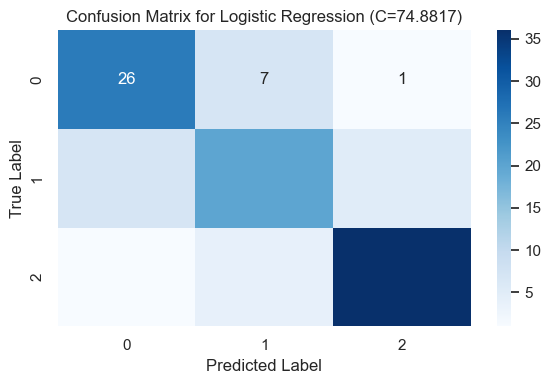


📌 Classification Report for XGBoost (max_depth=2):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        34
           1       0.97      0.88      0.92        32
           2       0.90      0.93      0.92        41

    accuracy                           0.93       107
   macro avg       0.94      0.93      0.94       107
weighted avg       0.94      0.93      0.93       107



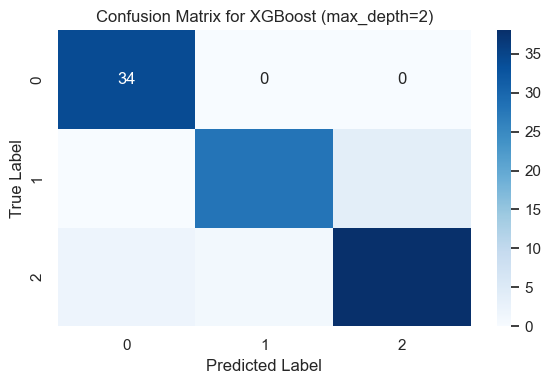

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

# Lặp và in Classification Report + Confusion Matrix với tham số chi tiết
for model_key in models_best:
    # Lấy từng mô hình
    model = models_best[model_key]
    
    # Tùy chỉnh tên hiển thị chi tiết theo từng model
    if "SVM" in model_key:
        display_name = f"SVM (C={best_c_svm:.4f})"
    elif "KNN" in model_key:
        display_name = f"KNN (k={best_k_knn})"
    elif "Logistic" in model_key:
        display_name = f"Logistic Regression (C={best_c_log:.4f})"
    elif "XGBoost" in model_key:
        display_name = f"XGBoost (max_depth={best_d_xgb})"
    else:
        display_name = model_key

    # Fit và dự đoán
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # In báo cáo
    print(f"\n📌 Classification Report for {display_name}:")
    print(classification_report(y_test, y_pred))

    # Vẽ confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {display_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()


In [32]:
# Danh sách lưu kết quả đánh giá
results_best = []

# Lặp qua models_best để đánh giá lại và lưu
for model_key in models_best:
    model = models_best[model_key]
    
    # Tùy chỉnh tên hiển thị chi tiết
    if "SVM" in model_key:
        display_name = f"SVM (C={best_c_svm:.4f})"
    elif "KNN" in model_key:
        display_name = f"KNN (k={best_k_knn})"
    elif "Logistic" in model_key:
        display_name = f"Logistic Regression (C={best_c_log:.4f})"
    elif "XGBoost" in model_key:
        display_name = f"XGBoost (max_depth={best_d_xgb})"
    else:
        display_name = model_key

    # Fit và predict
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Tính các độ đo
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Lưu vào danh sách
    results_best.append({
        "Model": display_name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    })

# Tạo DataFrame
results_df_best = pd.DataFrame(results_best)

C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kiet6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

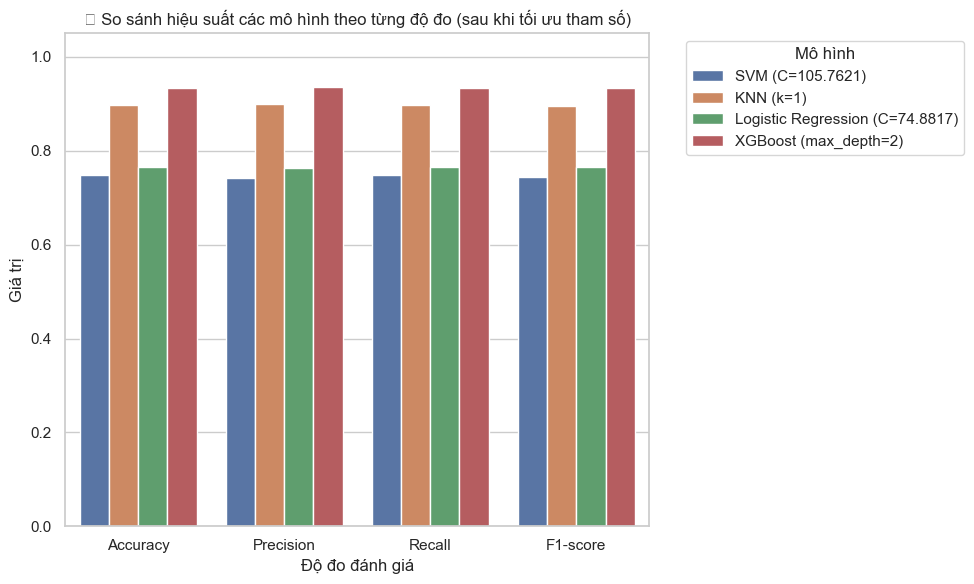

In [33]:
# Chuyển sang dạng "long" để vẽ cột
results_melted_best = results_df_best.melt(
    id_vars="Model",
    value_vars=["Accuracy", "Precision", "Recall", "F1-score"],
    var_name="Metric",
    value_name="Score"
)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(data=results_melted_best, x="Metric", y="Score", hue="Model")
plt.title("📊 So sánh hiệu suất các mô hình theo từng độ đo (sau khi tối ưu tham số)")
plt.ylabel("Giá trị")
plt.ylim(0, 1.05)
plt.xlabel("Độ đo đánh giá")
plt.legend(title="Mô hình", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
